<h1>Geocoding Notebook - Sierra Leone<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Packages-and-functions" data-toc-modified-id="Packages-and-functions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Packages and functions</a></span></li><li><span><a href="#Prepare-and-match-admin-boundary-data" data-toc-modified-id="Prepare-and-match-admin-boundary-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Prepare and match admin boundary data</a></span><ul class="toc-item"><li><span><a href="#Match-health-list-admin-names-to-shapefile-admin-names" data-toc-modified-id="Match-health-list-admin-names-to-shapefile-admin-names-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Match health list admin names to shapefile admin names</a></span><ul class="toc-item"><li><span><a href="#Match-orgunitlevel4-to-geoboundaries-Adm-3" data-toc-modified-id="Match-orgunitlevel4-to-geoboundaries-Adm-3-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Match orgunitlevel4 to geoboundaries Adm 3</a></span></li><li><span><a href="#Match-orgunitlevel3-to-GeoBoundaries-Adm-2" data-toc-modified-id="Match-orgunitlevel3-to-GeoBoundaries-Adm-2-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Match orgunitlevel3 to GeoBoundaries Adm 2</a></span></li></ul></li></ul></li><li><span><a href="#Match-to-locations-from-alternative-sources-based-on-facility-name" data-toc-modified-id="Match-to-locations-from-alternative-sources-based-on-facility-name-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Match to locations from alternative sources based on facility name</a></span><ul class="toc-item"><li><span><a href="#Health-Sites-IO" data-toc-modified-id="Health-Sites-IO-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Health Sites IO</a></span></li><li><span><a href="#RHINoVision-Master-Facility-List-Decision-Support-System" data-toc-modified-id="RHINoVision-Master-Facility-List-Decision-Support-System-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>RHINoVision Master Facility List Decision Support System</a></span></li></ul></li><li><span><a href="#Geocoding-with-APIs" data-toc-modified-id="Geocoding-with-APIs-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Geocoding with APIs</a></span><ul class="toc-item"><li><span><a href="#Facility-name-and-admin-3-names" data-toc-modified-id="Facility-name-and-admin-3-names-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Facility name and admin 3 names</a></span></li><li><span><a href="#Facility-name-and-admin-2-names" data-toc-modified-id="Facility-name-and-admin-2-names-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Facility name and admin 2 names</a></span></li><li><span><a href="#Admin-3-names" data-toc-modified-id="Admin-3-names-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Admin 3 names</a></span></li><li><span><a href="#Admin-3--and-admin-2-names" data-toc-modified-id="Admin-3--and-admin-2-names-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Admin 3  and admin 2 names</a></span></li></ul></li><li><span><a href="#Map-and-save-results" data-toc-modified-id="Map-and-save-results-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Map and save results</a></span><ul class="toc-item"><li><span><a href="#Join-attributes-from-adminsitrative-polygons" data-toc-modified-id="Join-attributes-from-adminsitrative-polygons-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Join attributes from adminsitrative polygons</a></span></li></ul></li></ul></div>

Version: January 23, 2023

This notebook works with health facilities from the HMIS Database and attempts to geolocate them, by joining them to administrative shapefiles, other sources of geo-located health facilities, and running queries with geocoding APIs.

**Data Sources**
- Health facilities (hierarchy list)
- Geoboundaries (Adm1 through 4)
- FEWS Admin-2 boundaries (updated post 2017)
- Health Sites IO
- RHINoVision Master Facility List Decision Support System

# Packages and functions

In [1]:
import os, sys
import geopandas as gpd
import pandas as pd
from geopy.geocoders import GeoNames, Nominatim, Bing, GoogleV3
from shapely.geometry import Point
from tqdm.notebook import tqdm
from thefuzz import process
import matplotlib.pyplot as plt
from string import ascii_uppercase
import contextily as ctx
from os.path import join
from dotenv import load_dotenv, find_dotenv

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
repo_dir = os.path.expanduser("~/Repos/health-equity-diagnostics/src/modules")
sys.path.append(repo_dir)

In [4]:
from geocoder import *

In [5]:
iso3 = "GIN"
country = "Guinea"
input_dir = "/home/public/Data/PROJECTS/Health" 
output_dir = join(input_dir, "output", iso3)
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

# Prepare and match admin boundary data 

In [6]:
try:
    geob4 = gpd.read_file(f"https://github.com/wmgeolab/geoBoundaries/raw/b7dd6a5/releaseData/gbOpen/{iso3}/ADM4/geoBoundaries-{iso3}-ADM4.geojson")
except:
    print('No adm4 available')
try:
    geob3 = gpd.read_file(f"https://github.com/wmgeolab/geoBoundaries/raw/b7dd6a5/releaseData/gbOpen/{iso3}/ADM3/geoBoundaries-{iso3}-ADM3.geojson")
except:
    print('No adm3 available')

geob2 = gpd.read_file(f"https://github.com/wmgeolab/geoBoundaries/raw/b7dd6a5/releaseData/gbOpen/{iso3}/ADM2/geoBoundaries-{iso3}-ADM2.geojson")
geob1 = gpd.read_file(f"https://github.com/wmgeolab/geoBoundaries/raw/b7dd6a5/releaseData/gbOpen/{iso3}/ADM1/geoBoundaries-{iso3}-ADM1.geojson")

No adm4 available


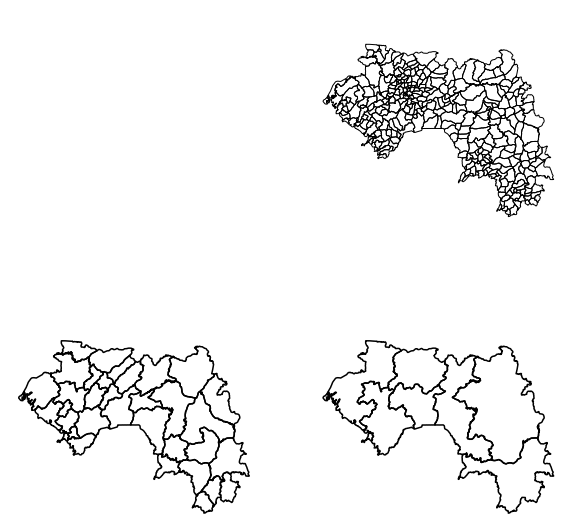

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))
# geob4.boundary.plot(ax=ax[0, 0], color='black', linewidth=0.5).set_axis_off()
ax[0,0].set_axis_off()
geob3.boundary.plot(ax=ax[0, 1], color='black', linewidth=1).set_axis_off()
geob2.boundary.plot(ax=ax[1, 0], color='black').set_axis_off()
geob1.boundary.plot(ax=ax[1, 1], color='black').set_axis_off()
# plt.axis('off')

In [8]:
master_table = pd.read_csv(join(input_dir, "tom_formatted", "hierarchy", "tom_edited_guinea_collapsed.csv"), encoding='utf-8')

In [9]:
master_table.head(2)

,orgunitlevel1,orgunitlevel2,orgunitlevel3,orgunitlevel4,orgunitlevel5
0,Guinée,Boké,Boffa,Boffa Centre,CSU de Boffa
1,Guinée,Boké,Boffa,Boffa Centre,Hôpital préfectoral de Boffa


In [10]:
len(master_table)

481

In [11]:
print(f"Unique Level 2: {len(master_table.orgunitlevel2.unique())}")
print(f"Unique Level 3: {len(master_table.orgunitlevel3.unique())}")
print(f"Unique Level 4: {len(master_table.orgunitlevel4.unique())}")
print(f"Unique Level 5: {len(master_table.orgunitlevel5.unique())}")

Unique Level 2: 8
Unique Level 3: 38
Unique Level 4: 340
Unique Level 5: 478


In [12]:
print(f"Unique Geoboundaries Adm 1: {len(geob1)}")
print(f"Unique Geoboundaries Adm 2: {len(geob2)}")
print(f"Unique Geoboundaries Adm 3: {len(geob3)}")
# print(f"Unique Geoboundaries Adm 4: {len(geob4)}")

Unique Geoboundaries Adm 1: 8
Unique Geoboundaries Adm 2: 34
Unique Geoboundaries Adm 3: 340


## Match health list admin names to shapefile admin names
### Match orgunitlevel4 to geoboundaries Adm 3
Try using fuzzy matching  

In [13]:
level4_list = list(master_table.orgunitlevel4.unique())
level4_list.sort()
geob3_list = list(geob3.shapeName)
geob3_list.sort()

Print names to inspect

In [15]:
for letter in ascii_uppercase:
    level4_sublist = [name for name in level4_list if name[0]==letter]
    geob3_sublist = [name for name in geob3_list if name[0]==letter]

    if len(level4_sublist)>0:
        print("Master list level 4")
        print("\t"+str(level4_sublist))
    if len(geob3_sublist) >0:
        print("Geoboundaries adm3")
        print("\t"+str(geob3_sublist))
        
    print("\n")

Master list level 4
	['Albadariah', 'Allassoyah', 'Arfamoussayah']
Geoboundaries adm3
	['Albadariah', 'Allassoyah', 'Arfamoussayah']


Master list level 4
	['Babila', 'Badi', 'Baguinet', 'Balaki', 'Balandou', 'Balandougouba', 'Balato', 'Balaya', 'Balizia', 'Banama', 'Banankoro', 'Banfélé', 'Bangouya', 'Banguigny', 'Banian', 'Banié', 'Banko', 'Bankon', 'Banora', 'Bantignel', 'Bardou', 'Baro', 'Baté Nafadji', 'Beindou', 'Benty', 'Beyla Centre', 'Bheeta', 'Bignamou', 'Binikala', 'Bintimodia', 'Bissikrima', 'Bodié', 'Boffa Centre', 'Bofossou', 'Boké Centre', 'Bolodou', 'Boola', 'Bossou', 'Boula', 'Boulliwel', 'Bounouma', 'Bourouwal', 'Bowé', 'Brouwal Tapé']
Geoboundaries adm3
	['Babila', 'Badi', 'Baguinet', 'Balaki', 'Balandougou', 'Balandougouba', 'Balato', 'Balaya', 'Balizia', 'Banama', 'Banankoro', 'Banfele', 'Bangouya', 'Banguigny', 'Banian', 'Banie', 'Banko', 'Bankon', 'Banora', 'Bantignel', 'Bardou', 'Baro', 'Bate Nafadji', 'Beindou', 'Beindou', 'Benty', 'Beyla Ctre', 'Bheeta', 'Bign

Manually adjust spellings of master health list to create more matches.

In [16]:
master_table.loc[:, "orgunitlevel4_edit"] = master_table.orgunitlevel4

In [17]:
# master_table.loc[master_table.orgunitlevel4 == "Bo City", "orgunitlevel4_edit"] = "Bo Town"

Remove key words that confuse matching algorithm

In [18]:
remove_words(geob3, "shapeName", ['Town', 'City', 'Urban', 'Zone'])
remove_words(master_table, "orgunitlevel4_edit", ['Town', 'City', 'Urban', 'Zone'])

In [19]:
# level4_list = list(master_table.orgunitlevel4.unique())
level4_list = list(master_table.orgunitlevel4_edit.unique())
level4_list.sort()
geob3_list = list(geob3.shapeName)
geob3_list.sort()

In [20]:
# List for dicts for easy dataframe creation
dict_list = []
# iterating over our players without salaries found above
for name in level4_list:
    
    # Use our method to find best match, we can set a threshold here
    match = match_name(name, geob3_list, 30)

    # New dict for storing data
    dict_ = {}
    dict_.update({"name_level4" : name})
    dict_.update({"name_geob3" : match[0]})
    dict_.update({"score" : match[1]})
    dict_list.append(dict_)

table_adm3 = pd.DataFrame(dict_list)
table_adm3_matches = table_adm3[table_adm3.score >= 70].copy()

In [21]:
matches_pct = (len(table_adm3_matches) / len(level4_list))
'{:.2f}%'.format(matches_pct*100)

'97.94%'

In [22]:
# for idx, row in table_adm3_matches.loc[table_adm3_matches.score<80].iterrows():
#     print(row)
#     drop_input = input("Drop? If no, leave blank: ")
#     print('\n')
#     if len(drop_input)>0:
#         table_adm3_matches.drop(idx, axis=0, inplace=True)

In [23]:
# could save this list for someone to confirm matches manually
# for now take input noting which ones should be dropped based on quick inspection
table_adm3_matches.loc[table_adm3_matches.score<80]

,name_level4,name_geob3,score
14,Banfélé,Banfele,71
45,Bowé,Bowe,75
63,Diatiféré,Diatifere,78
189,Kégnéko,Kegneko,71
190,Kérouané Centre,Kerouane Ctre,79
223,Matam SP,Matam,77
245,Nounkounkan,Youkounkoun,73
249,Nzébéla,Nzebela,71
250,Nzérékoré Centre,Nzerekore Ctre,73
252,Ouendé Kénéma,Ouende Kenema,77


In [24]:
table_adm3_matches.drop(
    table_adm3_matches.loc[table_adm3_matches.name_level4=="Tindo"].index[0],
    axis=0, 
    inplace=True
    )

In [25]:
matches_pct = (len(table_adm3_matches) / len(level4_list))
'{:.2f}%'.format(matches_pct*100)

'97.65%'

### Match orgunitlevel3 to GeoBoundaries Adm 2

In [26]:
master_table.loc[:, "orgunitlevel3_edit"] = master_table.orgunitlevel3

In [30]:
remove_words(master_table, "orgunitlevel3_edit", [" District"])
remove_words(master_table, "orgunitlevel3_edit", [" Prefecture"])

In [31]:
level3_list = list(master_table.orgunitlevel3_edit.unique())
level3_list.sort()
geob2_list = list(geob2.shapeName)
geob2_list.sort()

In [32]:
for letter in ascii_uppercase:
    level3_sublist = [name for name in level3_list if name[0]==letter]
    geob2_sublist = [name for name in geob2_list if name[0]==letter]
    if len(level3_sublist)>0:
        print("Master list level 2")
        print("\t"+str(level3_sublist))
    if len(geob2_sublist) >0:
        print("Geoboundaries adm2")
        print("\t"+str(geob2_sublist))
    print("\n")



Master list level 2
	['Beyla', 'Boffa', 'Boké']
Geoboundaries adm2
	['Beyla', 'Boffa', 'Boke']


Master list level 2
	['Coyah']
Geoboundaries adm2
	['Conakry', 'Coyah']


Master list level 2
	['Dabola', 'Dalaba', 'Dinguiraye', 'Dixinn', 'Dubréka']
Geoboundaries adm2
	['Dabola', 'Dalaba', 'Dinguiraye', 'Dubreka']




Master list level 2
	['Faranah', 'Forécariah', 'Fria']
Geoboundaries adm2
	['Faranah', 'Forecariah', 'Fria']


Master list level 2
	['Gaoual', 'Guéckédou']
Geoboundaries adm2
	['Gaoual', 'Gueckedou']








Master list level 2
	['Kaloum', 'Kankan', 'Kindia', 'Kissidougou', 'Koubia', 'Koundara', 'Kouroussa', 'Kérouané']
Geoboundaries adm2
	['Kankan', 'Kerouane', 'Kindia', 'Kissidougou', 'Koubia', 'Koundara', 'Kouroussa']


Master list level 2
	['Labé', 'Lola', 'Lélouma']
Geoboundaries adm2
	['Labe', 'Lelouma', 'Lola']


Master list level 2
	['Macenta', 'Mali', 'Mamou', 'Mandiana', 'Matam', 'Matoto']
Geoboundaries adm2
	['Macenta', 'Mali', 'Mamou', 'Mandiana']


Master lis

In [33]:
# List for dicts for easy dataframe creation
dict_list = []
# iterating over our players without salaries found above
for name in level3_list:
    
    # Use our method to find best match, we can set a threshold here
    match = match_name(name, geob2_list, 30)

    # New dict for storing data
    dict_ = {}
    dict_.update({"name_level3" : name})
    dict_.update({"name_geob2" : match[0]})
    dict_.update({"score" : match[1]})
    dict_list.append(dict_)

table_adm2 = pd.DataFrame(dict_list)
table_adm2_matches = table_adm2[table_adm2.score > 70]

In [34]:
table_adm2_matches.loc[table_adm2_matches.score<80]

,name_level3,name_geob2,score
2,Boké,Boke,75
13,Guéckédou,Gueckedou,78
21,Kérouané,Kerouane,75
22,Labé,Labe,75


In [35]:
matches_pct = (len(table_adm2_matches) / len(level3_list))
'{:.2f}%'.format(matches_pct*100)

'81.58%'

Loop through each row in master table, and add new attribute names (adm3 and adm2), if the names produced matches in the lookup tables

In [36]:
master_table_copy = master_table.copy()

In [37]:
for idx, row in tqdm(master_table_copy.iterrows()):
    
    if row.orgunitlevel4_edit in list(table_adm3_matches.name_level4):
        
        match = table_adm3_matches.loc[table_adm3_matches.name_level4==row.orgunitlevel4_edit, "name_geob3"].iloc[0]
        master_table_copy.loc[idx, 'adm3'] = match
        
    if row.orgunitlevel3_edit in list(table_adm2_matches.name_level3):
        
        match = table_adm2_matches.loc[table_adm2_matches.name_level3==row.orgunitlevel3_edit, "name_geob2"].iloc[0]
        master_table_copy.loc[idx, 'adm2'] = match

481it [00:00, 944.41it/s]


In [38]:
master_table_copy.adm2.isna().sum()

76

In [39]:
master_table_copy.adm3.isna().sum()

12

In [40]:
master_table_copy.head(2)

,orgunitlevel1,orgunitlevel2,orgunitlevel3,orgunitlevel4,orgunitlevel5,orgunitlevel4_edit,orgunitlevel3_edit,adm3,adm2
0,Guinée,Boké,Boffa,Boffa Centre,CSU de Boffa,Boffa Centre,Boffa,Boffa Ctre,Boffa
1,Guinée,Boké,Boffa,Boffa Centre,Hôpital préfectoral de Boffa,Boffa Centre,Boffa,Boffa Ctre,Boffa


# Match to locations from alternative sources based on facility name


## Health Sites IO
Import Health Sites from HealthSites.io  
Health sites come in both a node and a way shapefile. You need to import both to get all the sites.  
In QGIS, I created centroids from the ways then merged it with the points.

In [41]:
healthsitesio_ways = gpd.read_file(join(input_dir, "healthsitesio", "GIN", "Guinea-way.shp"))
healthsitesio_nodes = gpd.read_file(join(input_dir, "healthsitesio", "GIN", "Guinea-node.shp"))

In [42]:
healthsitesio_ways.loc[:, "geometry"] = healthsitesio_ways.geometry.representative_point()

In [43]:
nodes_io = pd.concat([healthsitesio_ways, healthsitesio_nodes])

In [44]:
len(nodes_io.loc[nodes_io.geometry.type=='Point']), len(nodes_io)

(995, 995)

In [45]:
nodes_io = nodes_io.loc[~nodes_io.name.isna()].copy()

In [46]:
nodes_io['name'] = nodes_io['name'].str.lower()

In [47]:
len(nodes_io)

951

In [48]:
words_to_remove = ['community', 'clinic', 'centre', 'center', 'hospital', 'health', 'government']

In [49]:
records = master_table_copy.copy()
records['NAME'] = records['orgunitlevel5'].str.lower()

In [50]:
remove_words(nodes_io, 'name', words_to_remove)
remove_words(records, 'NAME', words_to_remove)

In [51]:
records['geocoding_method'] = "None"

In [52]:
geob2.head(2)

,shapeName,shapeISO,shapeID,shapeGroup,shapeType,geometry
0,Beyla,,49546643B96027163767081,GIN,ADM2,"POLYGON ((-8.24559 8.44255, -8.24350 8.44472, ..."
1,Boffa,,49546643B4254869790359,GIN,ADM2,"MULTIPOLYGON (((-13.77147 9.84445, -13.76994 9..."


In [53]:
for idx, row in tqdm(records.iterrows()):
    
    # Check if there is another entry with location
    match, score = match_name(row.NAME, list(nodes_io['name']), 75)
#     match, score = match_name(row.name_concat, list(nodes_io.name_concat), 85)
    
    if score > 0:
        print(row.NAME, match)
        matching_row = nodes_io.loc[nodes_io['name']==match].copy()
        res = matching_row.iloc[0]
        
        if not pd.isna(row.adm3):
            adm3 = geob3.loc[geob3['shapeName'] == row['adm3']].copy()
            if adm3.contains(res.geometry).values[0] == True:
                records.loc[idx, "longitude"] = res.geometry.x
                records.loc[idx, "latitude"] = res.geometry.y
                records.loc[idx, "geocoding_method"] = "Location from Health Sites IO"
        else:
            adm2 = geob2.loc[geob2['shapeName'] == row['adm2']].copy()
            if adm2.contains(res.geometry).values[0] == True:            
                records.loc[idx, "longitude"] = res.geometry.x
                records.loc[idx, "latitude"] = res.geometry.y
                records.loc[idx, "geocoding_method"] = "Location from Health Sites IO"

57it [00:00, 275.98it/s]

hôpital préfectoral de boffa hôpital préfectoral de boffa
hopital régional de boke hôpital régional de boké
csr de kassapo cs de kassa
csr de kayenguissa cs de kassa
hôpital préfectoral de fria hôpital préfectoral de pita
hôpital préfectoral de gaoual hôpital préfectoral de koubia
hôpital préfectoral koundara hôpital préfectoral de koubia
csr de sambailo cs-sambailo
hn de donka chu de donka
csr de kassa cs de kassa
hn de ignace deen chu ignace deen


119it [00:00, 292.06it/s]

csu tanene cs_tanene
csu de wanindara cs_wanindara
hopital amitie sino-guinéen hôpital de l'amitié sino-guinéenne
csr de arfamoussaya (cs)arfamoussaya
csu de hamdallaye clinique hamdallaye
csr de passaya cs de kassa


224it [00:00, 318.96it/s]

hp de mandiana hôpital de mandiana
csu de doumbouyah de santé de doumbouyah
csr de wonkifong cs_wonkifong
csu de ansoumania plateau ansoumanya plateau
csr de damankanya cds danmakanya
csu wondy cs_wondy


325it [00:01, 328.26it/s]

csr de konsotami cs_konsotami
csu de daka chu de donka


391it [00:01, 326.63it/s]

hp de dalaba hôpital de dalaba
csr de kaala cs de kassa
csr de bantignel de santé de bantignel
csr de doghol touma de santé de donghol touma
csr de fangamadou de santé de fangamadou


458it [00:01, 325.21it/s]

csr de kassadou cs de kassa
csr de nongoa insp de nongo
de santé urbain tp de santé boulbinet
agbef agebef


481it [00:01, 320.83it/s]


In [54]:
report_geocoding(records)

,count,pct
geocoding_method,,
Location from Health Sites IO,17,3.5%
None,464,96.5%


## RHINoVision Master Facility List Decision Support System

In [55]:
rhino = pd.read_excel(os.path.join(input_dir, "rhino", "00 SSA MFL (130219).xlsx"), 0)

In [56]:
rhino = rhino.loc[rhino.Country=="Guinea"].copy()

In [57]:
rhino['name'] = rhino['Facility name'].str.lower()

In [58]:
# rhino.head()

In [59]:
remove_words(rhino, 'name')

In [60]:
rhino.loc[:, "geometry"] = rhino.apply(lambda x: Point(x.Long, x.Lat), axis=1)
rhino = gpd.GeoDataFrame(rhino, geometry='geometry', crs='EPSG:4326')

In [66]:
rhino.head(2)

,Country,Admin1,Facility name,Facility type,Ownership,Lat,Long,LL source,name,geometry
35478,Guinea,Boke,Bakoro Poste de Santé,Poste de Santé,NaN,10.318508,-14.008081,Geonames,bakoro poste de santé,POINT (-14.00808 10.31851)
35479,Guinea,Boke,Balandougou Poste de Santé,Poste de Santé,NaN,10.928832,-13.885175,GPS,balandougou poste de santé,POINT (-13.88517 10.92883)


In [61]:
for idx, row in tqdm(records.iterrows()):
    
    if row.geocoding_method=="None":
        
        # Check if there is another entry with location
        match, score = match_name(row.NAME, list(rhino['name']), 75)

        if score > 0:
            print(row.NAME, match)
            matching_row = rhino.loc[rhino['name']==match].copy()
            res = matching_row.iloc[0]
            
            if not pd.isna(row.adm3):
                adm3 = geob3.loc[geob3['shapeName'] == row['adm3']].copy()
                if adm3.contains(res.geometry).values[0] == True:
                    records.loc[idx, "longitude"] = res.geometry.x
                    records.loc[idx, "latitude"] = res.geometry.y
                    records.loc[idx, "geocoding_method"] = "Location from Rhino Dataset"
                    records.loc[idx, "source"] = res["LL source"]
            else:
                adm2 = geob2.loc[geob2['shapeName'] == row['adm2']].copy()
                if adm2.contains(res.geometry).values[0] == True:            
                    records.loc[idx, "longitude"] = res.geometry.x
                    records.loc[idx, "latitude"] = res.geometry.y
                    records.loc[idx, "geocoding_method"] = "Location from Rhino Dataset"
                    records.loc[idx, "source"] = res["LL source"]

481it [00:02, 201.11it/s]


In [67]:
report_geocoding(records)

,count,pct
geocoding_method,,
Location from Health Sites IO,17,3.5%
None,464,96.5%


# Geocoding with APIs

## Facility name and admin 3 names

Geocode based on facility name (orgunitlevel5) + admin 3 name.  
Check to make sure result falls within admin 3 polygon.

In [92]:
records_subset = records.loc[records.geocoding_method=="None"].copy()
# only include trying to geocode rows that have an admin name that is matched to the Geoboundaries file
records_subset = records_subset.loc[~records_subset.adm3.isna()].copy()

In [93]:
len(records_subset)

452

In [94]:
records_subset.head(2)

,orgunitlevel1,orgunitlevel2,orgunitlevel3,orgunitlevel4,orgunitlevel5,orgunitlevel4_edit,orgunitlevel3_edit,adm3,adm2,NAME,geocoding_method,longitude,latitude
0,Guinée,Boké,Boffa,Boffa Centre,CSU de Boffa,Boffa Centre,Boffa,Boffa Ctre,Boffa,csu de boffa,None,NaN,NaN
2,Guinée,Boké,Boffa,Douprou,CSR de Douprou,Douprou,Boffa,Douprou,Boffa,csr de douprou,None,NaN,NaN


In [95]:
for idx, row in tqdm(records_subset.iterrows()):
    
    adm3 = geob3.loc[geob3['shapeName'] == row['adm3']].copy()
    run_geocoding(idx, row, records, adm3, ['NAME', 'adm3'], 'gn')

452it [04:21,  1.73it/s]


In [97]:
report_geocoding(records)

,count,pct
geocoding_method,,
Location from Health Sites IO,17,3.5%
NAME and adm3 query Bing,239,49.7%
NAME and adm3 query Google,130,27.0%
NAME and adm3 query OSM,2,0.4%
None,93,19.3%


In [103]:
records_subset = records.loc[records.geocoding_method=="None"].copy()
records_subset = records_subset.loc[~records_subset.adm3.isna()].copy()
records_subset = records_subset.loc[~records_subset.adm2.isna()].copy()

In [104]:
len(records_subset)

65

## Facility name and admin 2 names

Geocode based on facility name (orgunitlevel5) + admin 2 name.  
Check to make sure result falls within admin 3 polygon.

In [105]:
for idx, row in tqdm(records_subset.iterrows()):
    
    adm3 = geob3.loc[geob3['shapeName'] == row['adm3']].copy()
    run_geocoding(idx, row, records, adm3, ['NAME', 'adm2'], 'gn')

65it [00:39,  1.64it/s]


In [106]:
report_geocoding(records)

,count,pct
geocoding_method,,
Location from Health Sites IO,17,3.5%
NAME and adm2 query Bing,32,6.7%
NAME and adm2 query Google,9,1.9%
NAME and adm3 query Bing,239,49.7%
NAME and adm3 query Google,130,27.0%
NAME and adm3 query OSM,2,0.4%
None,52,10.8%


In [107]:
records_subset = records.loc[records.geocoding_method=="None"].copy()
records_subset = records_subset.loc[~records_subset.adm3.isna()].copy()

In [109]:
len(records_subset)

40

## Admin 3 names

Geocode based on admin 3 name.  
Check to make sure result falls within admin 3 polygon.  
If no result use admin 3 centroid.

In [110]:
orglev4_df = records_subset[['orgunitlevel4', 'orgunitlevel4_edit', 'adm3', 'orgunitlevel1']].drop_duplicates().copy()

In [111]:
orglev4_df.head(2)

,orgunitlevel4,orgunitlevel4_edit,adm3,orgunitlevel1
17,Kanfarandé,Kanfarandé,Kanfarande,Guinée
37,Touba,Touba,Touba,Guinée


In [112]:
len(orglev4_df)

33

In [113]:
for idx, row in tqdm(orglev4_df.iterrows()):
    
    adm3 = geob3.loc[geob3['shapeName'] == row['adm3']].copy()
    run_geocoding(idx, row, orglev4_df, adm3, ['orgunitlevel4', 'orgunitlevel1'], 'gn')

33it [00:20,  1.63it/s]


In [114]:
for idx, row in tqdm(orglev4_df.iterrows()):
    
    adm3 = geob3.loc[geob3['shapeName'] == row['adm3']].copy()
    if row.geocoding_method=="None":
        cent = adm3.geometry.representative_point().iloc[0]
        orglev4_df.loc[idx, "longitude"] = cent.x
        orglev4_df.loc[idx, "latitude"] = cent.y
        orglev4_df.loc[idx, "geocoding_method"] = "District centroid"

33it [00:00, 502.26it/s]


In [115]:
orglev4_df.geocoding_method.value_counts()

orgunitlevel4 and orgunitlevel1 query OSM       16
District centroid                               13
orgunitlevel4 and orgunitlevel1 query Google     4
Name: geocoding_method, dtype: int64

In [116]:
for idx, row in tqdm(records_subset.iterrows()):
    
    orglev4_geocoded = orglev4_df.loc[orglev4_df['orgunitlevel4']==row['orgunitlevel4']].iloc[0]    
    records.loc[idx, "longitude"] = orglev4_geocoded.longitude
    records.loc[idx, "latitude"] = orglev4_geocoded.latitude
    records.loc[idx, "geocoding_method"] = orglev4_geocoded.geocoding_method

40it [00:00, 905.23it/s]


In [135]:
report_geocoding(records)

,count,pct
geocoding_method,,
District centroid,17,3.5%
Location from Health Sites IO,17,3.5%
NAME and adm2 query Bing,32,6.7%
NAME and adm2 query Google,9,1.9%
NAME and adm3 query Bing,239,49.7%
NAME and adm3 query Google,130,27.0%
NAME and adm3 query OSM,2,0.4%
None,12,2.5%
orgunitlevel4 and orgunitlevel1 query Google,4,0.8%


In [137]:
records_subset = records.loc[records.geocoding_method=="None"].copy()
records_subset = records_subset.loc[~records_subset.adm2.isna()].copy()

In [138]:
len(records_subset)

9

## Admin 3  and admin 2 names

Geocode based on admin 3 name and admin 2 name.    
Check to make sure result falls within admin 2 polygon.  

In [139]:
orglev4_df = records_subset[['orgunitlevel4', 'orgunitlevel4_edit', 'adm2', 'orgunitlevel1']].drop_duplicates().copy()

In [140]:
len(orglev4_df)

7

In [141]:
for idx, row in tqdm(orglev4_df.iterrows()):
    
    adm2 = geob2.loc[geob2['shapeName'] == row['adm2']].copy()
    run_geocoding(idx, row, orglev4_df, adm2, ['orgunitlevel4', 'adm2'], 'gn')

7it [00:03,  2.13it/s]


In [142]:
orglev4_df.geocoding_method.value_counts()

orgunitlevel4 and adm2 query OSM     6
orgunitlevel4 and adm2 query Bing    1
Name: geocoding_method, dtype: int64

In [143]:
for idx, row in tqdm(records_subset.iterrows()):
    
    orglev4_geocoded = orglev4_df.loc[orglev4_df['orgunitlevel4']==row['orgunitlevel4']].iloc[0]    
    records.loc[idx, "longitude"] = orglev4_geocoded.longitude
    records.loc[idx, "latitude"] = orglev4_geocoded.latitude
    records.loc[idx, "geocoding_method"] = orglev4_geocoded.geocoding_method

9it [00:00, 789.13it/s]


In [144]:
report_geocoding(records)

,count,pct
geocoding_method,,
District centroid,17,3.5%
Location from Health Sites IO,17,3.5%
NAME and adm2 query Bing,32,6.7%
NAME and adm2 query Google,9,1.9%
NAME and adm3 query Bing,239,49.7%
NAME and adm3 query Google,130,27.0%
NAME and adm3 query OSM,2,0.4%
None,3,0.6%
orgunitlevel4 and adm2 query Bing,4,0.8%


In [145]:
records_subset = records.loc[records.geocoding_method=="None"].copy()

In [146]:
len(records_subset)

3

# Map and save results

In [147]:
results = records.copy()

In [148]:
results.geocoding_method.unique()

array(['NAME and adm3 query Bing', 'Location from Health Sites IO',
       'NAME and adm3 query Google', 'NAME and adm2 query Google',
       'NAME and adm2 query Bing', 'District centroid',
       'orgunitlevel4 and adm2 query Bing',
       'orgunitlevel4 and orgunitlevel1 query OSM',
       'NAME and adm3 query OSM',
       'orgunitlevel4 and orgunitlevel1 query Google',
       'orgunitlevel4 and adm2 query OSM', 'None'], dtype=object)

In [149]:
# facility name and adm 3
results.loc[results.geocoding_method=="NAME and adm3 query Bing", "geocoding_method"] = "orgunitlevel5 and adm3 query"
results.loc[results.geocoding_method=="NAME and adm3 query OSM", "geocoding_method"] = "orgunitlevel5 and adm3 query"
results.loc[results.geocoding_method=="NAME and adm3 query Google", "geocoding_method"] = "orgunitlevel5 and adm3 query"

# facility name and adm 2
results.loc[results.geocoding_method=="NAME and adm2 query Bing", "geocoding_method"] = "orgunitlevel5 and adm2 query"
results.loc[results.geocoding_method=="NAME and adm2 query OSM", "geocoding_method"] = "orgunitlevel5 and adm2 query"
results.loc[results.geocoding_method=="NAME and adm2 query Google", "geocoding_method"] = "orgunitlevel5 and adm2 query"

# adm 3 name
results.loc[results.geocoding_method=="orgunitlevel4 and orgunitlevel1 query Bing", "geocoding_method"] = "orgunitlevel4 query"
results.loc[results.geocoding_method=="orgunitlevel4 and orgunitlevel1 query OSM", "geocoding_method"] = "orgunitlevel4 query"
results.loc[results.geocoding_method=="orgunitlevel4 and orgunitlevel1 query Google", "geocoding_method"] = "orgunitlevel4 query"

# adm 3 name and adm2
results.loc[results.geocoding_method=="orgunitlevel4 and adm2 query Bing", "geocoding_method"] = "orgunitlevel4 and adm2 query"
results.loc[results.geocoding_method=="orgunitlevel4 and adm2 query OSM", "geocoding_method"] = "orgunitlevel4 and adm2 query"
results.loc[results.geocoding_method=="orgunitlevel4 and adm2 query Google", "geocoding_method"] = "orgunitlevel4 and adm2 query"

# Centroid
results.loc[results.geocoding_method=="District centroid", "geocoding_method"] = "Adm3 centroid"

In [150]:
report_geocoding(results)

,count,pct
geocoding_method,,
Adm3 centroid,17,3.5%
Location from Health Sites IO,17,3.5%
None,3,0.6%
orgunitlevel4 and adm2 query,9,1.9%
orgunitlevel4 query,23,4.8%
orgunitlevel5 and adm2 query,41,8.5%
orgunitlevel5 and adm3 query,371,77.1%


In [151]:
results.loc[:, "geometry"] = results.apply(lambda x: Point(x.longitude, x.latitude), axis=1)
results = gpd.GeoDataFrame(results, geometry='geometry', crs='EPSG:4326')

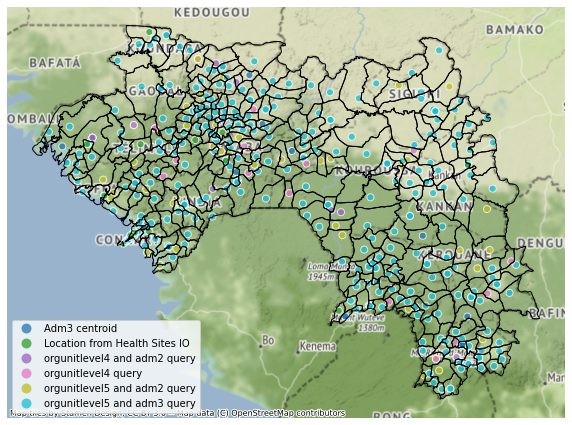

In [152]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
geob3.boundary.plot(ax=ax, color='black', linewidth=1).set_axis_off()
results.loc[results.geocoding_method!="None"].plot(ax=ax, column='geocoding_method', edgecolor='white', markersize=50, alpha=0.75, legend=True)
ctx.add_basemap(ax, source=ctx.providers.Stamen.Terrain, crs='EPSG:4326', zorder=-10)

## Join attributes from adminsitrative polygons

Join admin data back to results.  
For adm3 features, use spatial join to geob3.  

In [183]:
results2 = results.loc[~(results.longitude.isna())].copy()

In [184]:
records_subset = records.loc[records.geocoding_method=="None"].copy()

In [185]:
results2 = gpd.sjoin(results2, geob3[["shapeName", "shapeID", "geometry"]], how='left', predicate='intersects')
results2.drop('index_right', axis=1, inplace=True)

For adm2 features, use spatial join to geob2 first (excluding regions that were divided in 2017)  
Then use closest algorithm using FEWS NET adm 2 file.  
Ideally, we would just use the FEWS file, but it's resolution is not good enough to do intersects in border areas.

In [186]:
results2 = gpd.sjoin(results2, geob2[["shapeName", "shapeID", "geometry"]], how='left', predicate='intersects', lsuffix='adm2', rsuffix='adm3')
# results2.drop('index_right', axis=1, inplace=True)

In [187]:
results2.columns

Index(['orgunitlevel1', 'orgunitlevel2', 'orgunitlevel3', 'orgunitlevel4',
       'orgunitlevel5', 'orgunitlevel4_edit', 'orgunitlevel3_edit', 'adm3',
       'adm2', 'NAME', 'geocoding_method', 'longitude', 'latitude', 'geometry',
       'shapeName_adm2', 'shapeID_adm2', 'index_adm3', 'shapeName_adm3',
       'shapeID_adm3'],
      dtype='object')

In [188]:
results2.shapeName_adm3.isna().sum()

0

In [182]:
# results2.loc[results2.adm3!=results2.shapeName]

In [189]:
results2.rename(
    columns={
        'shapeName_adm3':'geob_adm3',
        'shapeID_adm3':'geob_adm3_id',
        'shapeName_adm2':'geob_adm2',
        'shapeID_adm2':'geob_adm2_id',
        'adm2':'fuzzy_match_adm2',
        'adm3':'fuzzy_match_adm3'
    }, inplace=True)

In [190]:
iso3

'GIN'

In [192]:
results_final = pd.concat([results2, records_subset])
results_final.sort_index(inplace=True)
results_final.to_csv(join(output_dir, f"{iso3}_geocoding_4.3.23.csv"))
results_final.to_file(join(output_dir, "f{iso3}_geocoding_4.3.23.json"), driver="GeoJSON")